# Получение и обработка данных

In [1]:
from src.data_loader import load_and_preprocess_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
filepath = "../data/Ad_click_prediction_train.csv"
X, y = load_and_preprocess_data(filepath)
df = X.join(y)
print(X.shape)
print(y.shape)
df.head()

Данные очищены от пропусков:
product               0
campaign_id           0
webpage_id            0
product_category_1    0
user_group_id         0
gender                0
age_level             0
user_depth            0
var_1                 0
hour                  0
weekday               0
dtype: int64
(463291, 11)
(463291,)


,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,var_1,hour,weekday,is_click
0,C,359520,13787,4,10.0,Female,4.0,3.0,0,0,6,0
1,C,105960,11085,5,8.0,Female,2.0,2.0,0,0,6,0
2,C,359520,13787,4,8.0,Female,2.0,2.0,0,0,6,0
3,I,359520,13787,3,3.0,Male,3.0,3.0,1,0,6,0
4,C,405490,60305,3,2.0,Male,2.0,3.0,1,0,6,0


## Обзор целевой переменной is_click

In [3]:
y_ones, y_zeros = y.value_counts()
y_ones, y_zeros

(431960, 31331)

<BarContainer object of 2 artists>

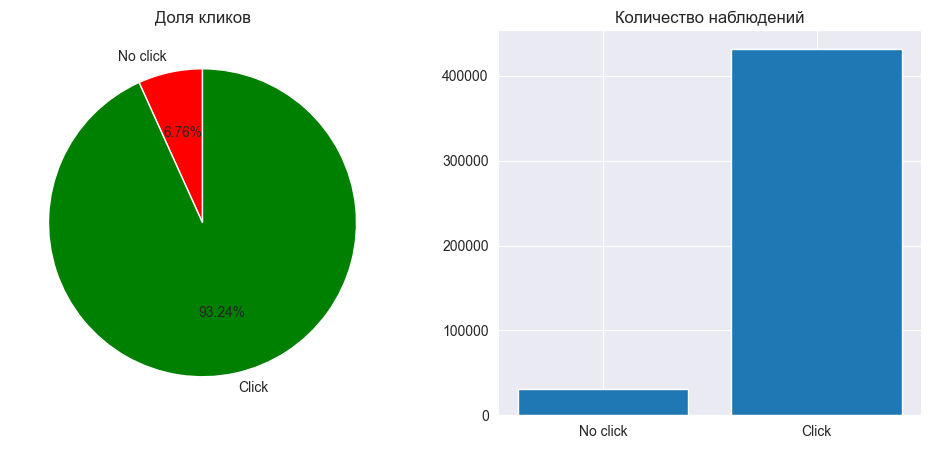

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("Доля кликов")
axes[0].pie([y_zeros,  y_ones],
            labels=["No click", "Click"],
            autopct="%1.2f%%",
            colors=["red", "green"],
            startangle=90)

axes[1].set_title("Количество наблюдений")
axes[1].bar([0, 1], [y_zeros, y_ones],
            tick_label=["No click", "Click"],
            width=0.8)


## Вывод

- Классы сильно несбалансированы: клики составляют примерно 6,76% от всех показов
- Accuracy будет вводить в заблуждение: попадание 93,24%, если все результаты - 0
- Буду использовать ROC-AUC  LogLoss как основные метрики оценки

## Анализ временных признаков

In [5]:
df_time = df[['hour', 'weekday','is_click']]
df_time.head()

,hour,weekday,is_click
0,0,6,0
1,0,6,0
2,0,6,0
3,0,6,0
4,0,6,0


In [6]:
hourly_data = df_time.groupby('hour')['is_click'].agg(['count', 'mean'])
weekday_data = df_time.groupby('weekday')['is_click'].agg(['count', 'mean'])

weekday_data

,count,mean
weekday,,
0,81380,0.074932
1,73085,0.072888
2,80789,0.060689
3,77526,0.062057
4,71466,0.061582
6,79045,0.073262


In [7]:
hourly_data

,count,mean
hour,,
0,2190,0.068493
1,1595,0.074608
2,1574,0.052732
3,4997,0.062237
4,10578,0.057005
5,14994,0.067027
6,20708,0.072822
7,24345,0.073978
8,25672,0.070271


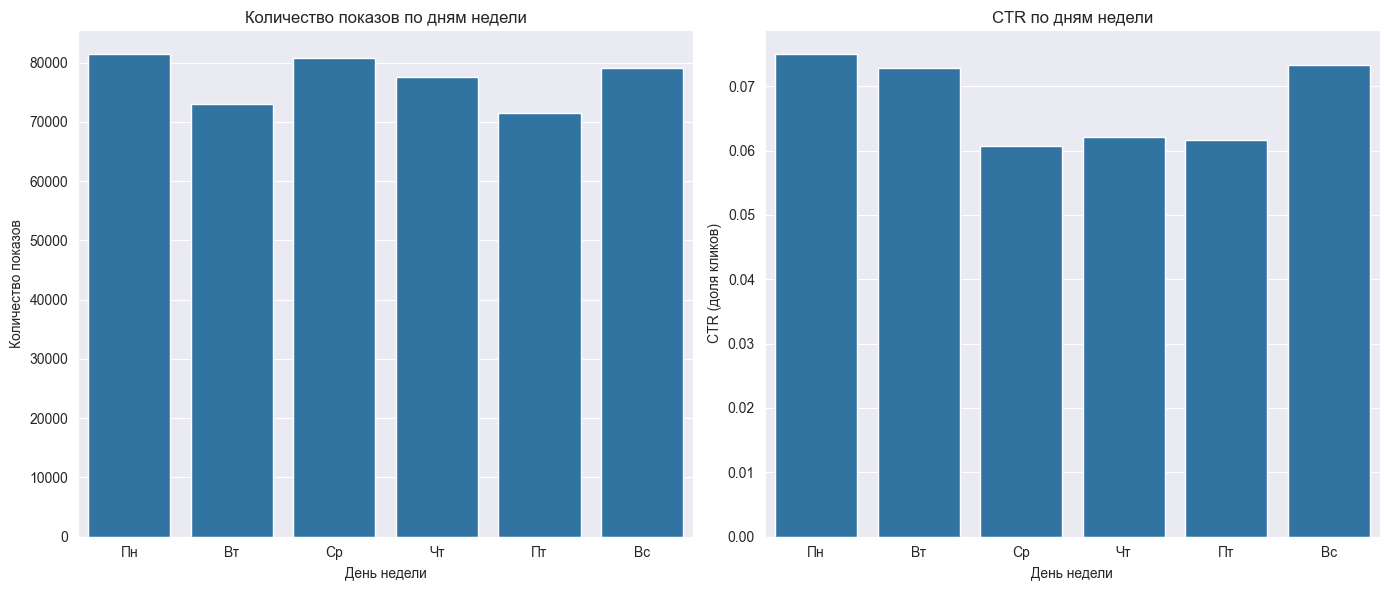

In [8]:
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Вс']
weekday_data['day_names'] = weekday_names

fig,axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='day_names', y='count', data=weekday_data, ax=axes[0])
axes[0].set_title('Количество показов по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество показов')

sns.barplot(x='day_names', y='mean', data=weekday_data, ax=axes[1])
axes[1].set_title('CTR по дням недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('CTR (доля кликов)')

plt.tight_layout()
plt.show()

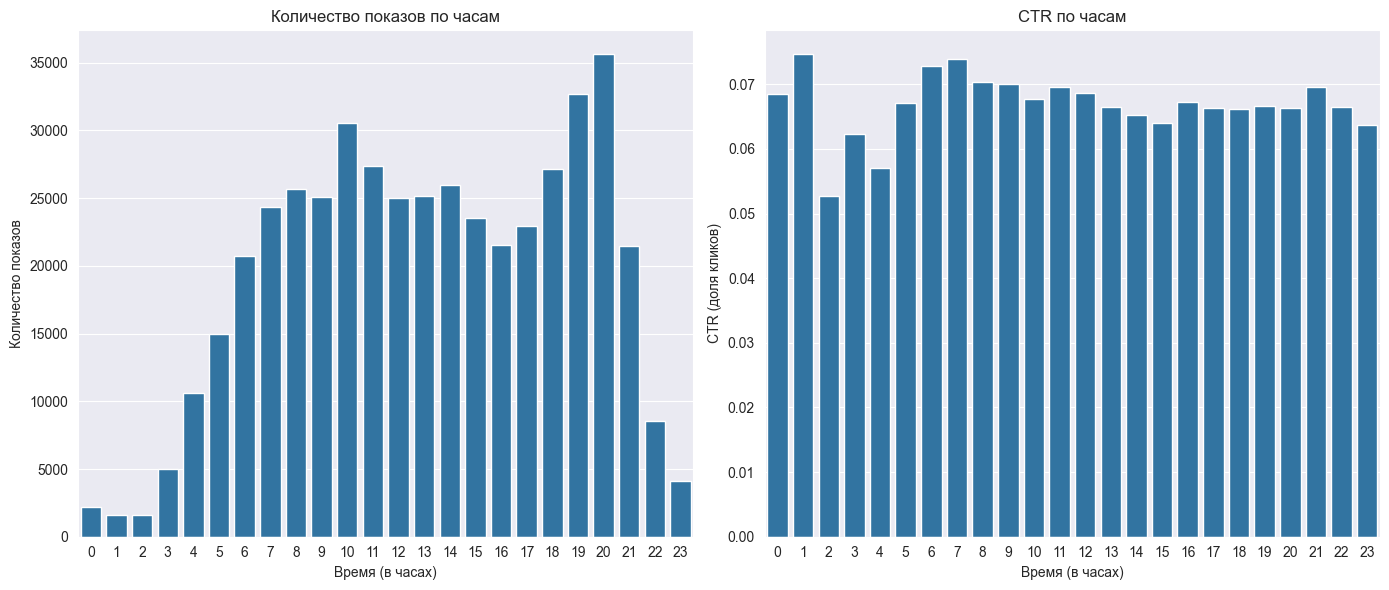

In [9]:
fig,axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='hour', y='count', data=hourly_data, ax=axes[0])
axes[0].set_title('Количество показов по часам')
axes[0].set_xlabel('Время (в часах)')
axes[0].set_ylabel('Количество показов')

sns.barplot(x='hour', y='mean', data=hourly_data, ax=axes[1])
axes[1].set_title('CTR по часам')
axes[1].set_xlabel('Время (в часах)')
axes[1].set_ylabel('CTR (доля кликов)')

plt.tight_layout()
plt.show()

In [10]:
# Нормализация относительно количества показов для более точных данных
hourly_data['mean_norm'] = hourly_data['mean'] / hourly_data['count']
weekday_data['mean_norm'] = weekday_data['mean'] / weekday_data['count']

best_CTR_hour = hourly_data.sort_values('mean_norm', ascending=False).iloc[0]
worst_CTR_hour = hourly_data.sort_values('mean_norm', ascending=True).iloc[0]
best_CTR_week = weekday_data.sort_values('mean_norm', ascending=False).iloc[0]
worst_CTR_week = weekday_data.sort_values('mean_norm', ascending=True).iloc[0]

print(f"Час с самым низким CTR: {worst_CTR_hour.name} (значение: {worst_CTR_hour['mean'] * 100:.2f}%)")
print(f"Час с самым высоким CTR: {best_CTR_hour.name} (значение: {best_CTR_hour['mean'] * 100:.2f}%)")
print(f"День с самым низким CTR: {worst_CTR_week['day_names']} (значение: {worst_CTR_week['mean'] * 100:.2f}%)")
print(f"День с самым высоким CTR: {best_CTR_week['day_names']} (значение: {best_CTR_week['mean'] * 100:.2f}%)")

Час с самым низким CTR: 20 (значение: 6.64%)
Час с самым высоким CTR: 1 (значение: 7.46%)
День с самым низким CTR: Ср (значение: 6.07%)
День с самым высоким CTR: Вт (значение: 7.29%)


## Вывод:
- CTR выше всего рано утром в начале недели (пик в 01:00 во вторник)
- Меньше всего кликают на рекламу в середине недели вечером (максимальный спад в 20:00 в среду)

## Анализ категориальных признаков

In [11]:
X.columns

Index(['product', 'campaign_id', 'webpage_id', 'product_category_1',
       'user_group_id', 'gender', 'age_level', 'user_depth', 'var_1', 'hour',
       'weekday'],
      dtype='object')

In [12]:
cat_cols = ['product', 'campaign_id', 'webpage_id', 'product_category_1',
                'user_group_id', 'gender', 'age_level', 'user_depth', 'var_1']

print("Категориальные признаки:")
print(*cat_cols, sep='\n')

Категориальные признаки:
product
campaign_id
webpage_id
product_category_1
user_group_id
gender
age_level
user_depth
var_1


In [28]:
def get_col_info(col, data: pd.DataFrame) -> None:
    print(col)
    print(f"Уникальные значения: {data[col].unique()}")
    print(f"Распределение:\n{data[col].value_counts()}")

    summary = data.groupby(col)['is_click'].agg(['count', 'mean']).sort_values('mean', ascending=False)
    summary['mean_%'] = summary['mean'] * 100
    display(summary.round(4))

    var = round(summary['mean_%'].iloc[0] - summary['mean_%'].iloc[-1], 4)
    print(f"Разброс значений 'mean_%': {var}")


    plt.figure(figsize=(10, 5))
    sns.barplot(x=summary.index.astype(str), y=summary['mean_%'])
    plt.title(f"CTR по значению {col}. Разброс: {var}")
    plt.xlabel(col)
    plt.ylabel("CTR %")
    plt.show()

product
Уникальные значения: ['C' 'I' 'F' 'H' 'B' 'D' 'G' 'E' 'J' 'A']
Распределение:
product
C    163501
H    109574
I     63711
D     41064
B     22479
E     21452
A     15391
J      9698
G      9414
F      7007
Name: count, dtype: int64


,count,mean,mean_%
product,,,
J,9698,0.0927,9.2700
D,41064,0.0718,7.1815
H,109574,0.0699,6.9852
C,163501,0.0691,6.9149
E,21452,0.0687,6.8712
I,63711,0.0640,6.4023
A,15391,0.0619,6.1919
B,22479,0.0551,5.5074
F,7007,0.0491,4.9094


Разброс значений 'mean_%': 4.6492


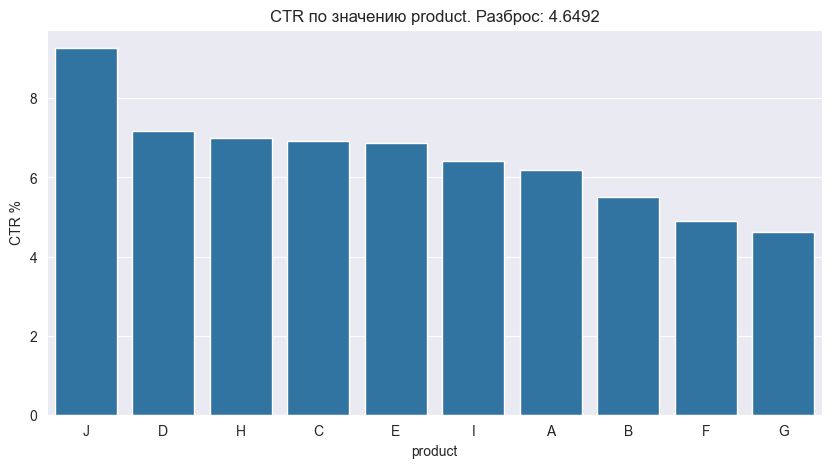

campaign_id
Уникальные значения: [359520 105960 405490 360936 404347  98970 414149  82320 396664 118601]
Распределение:
campaign_id
359520    108155
405490     95973
360936     51888
118601     35531
98970      35065
414149     29314
404347     28826
82320      27849
105960     25781
396664     24909
Name: count, dtype: int64


,count,mean,mean_%
campaign_id,,,
405490,95973,0.0913,9.1307
404347,28826,0.0775,7.7534
98970,35065,0.0768,7.6829
396664,24909,0.0726,7.2624
105960,25781,0.0683,6.8345
82320,27849,0.0638,6.3772
359520,108155,0.0586,5.8620
414149,29314,0.0583,5.8334
118601,35531,0.0534,5.3362


Разброс значений 'mean_%': 4.6094


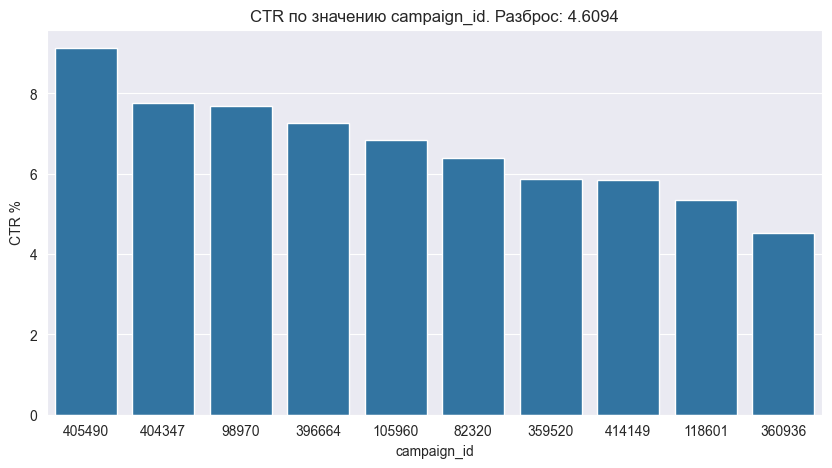

webpage_id
Уникальные значения: [13787 11085 60305 53587  6970 45962  1734 51181 28529]
Распределение:
webpage_id
13787    160043
60305     95973
28529     35531
6970      35065
45962     29314
53587     28826
1734      27849
11085     25781
51181     24909
Name: count, dtype: int64


,count,mean,mean_%
webpage_id,,,
60305,95973,0.0913,9.1307
53587,28826,0.0775,7.7534
6970,35065,0.0768,7.6829
51181,24909,0.0726,7.2624
11085,25781,0.0683,6.8345
1734,27849,0.0638,6.3772
45962,29314,0.0583,5.8334
13787,160043,0.0543,5.4273
28529,35531,0.0534,5.3362


Разброс значений 'mean_%': 3.7945


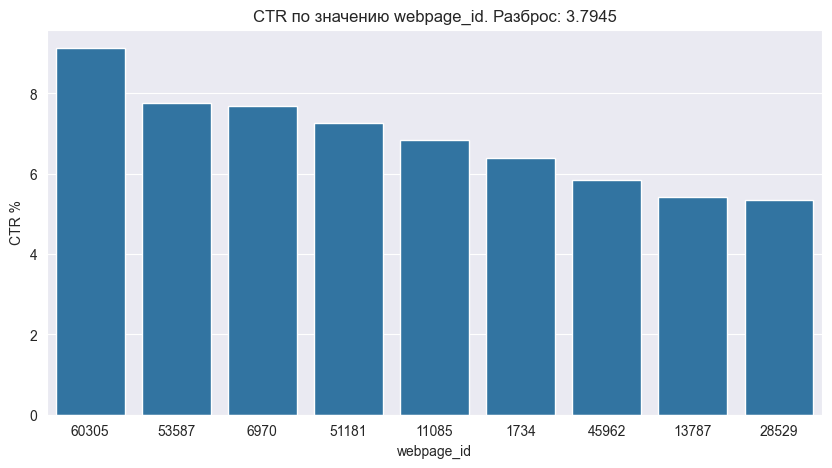

product_category_1
Уникальные значения: [4 5 3 2 1]
Распределение:
product_category_1
4    133290
3    113812
1     81141
2     69183
5     65865
Name: count, dtype: int64


,count,mean,mean_%
product_category_1,,,
3,113812,0.0835,8.3524
1,81141,0.0716,7.1554
2,69183,0.0617,6.1720
5,65865,0.0591,5.9121
4,133290,0.0589,5.8932


Разброс значений 'mean_%': 2.4592


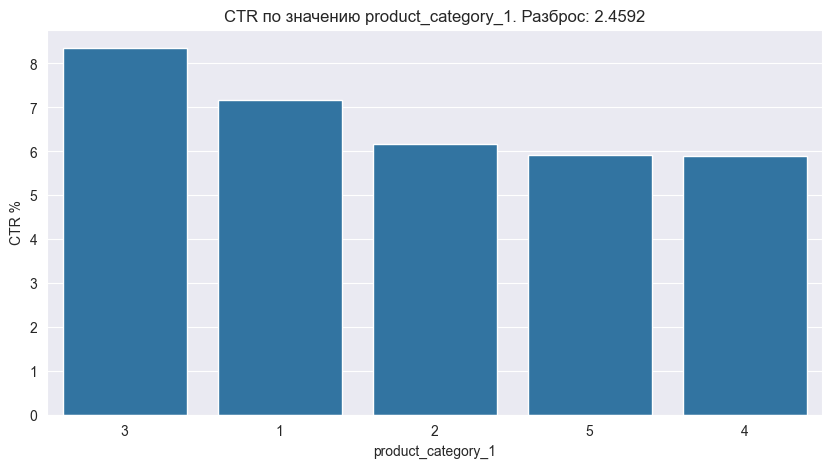

user_group_id
Уникальные значения: [10.  8.  3.  2.  1.  9.  4. 11.  7.  5. 12.  6.  0.]
Распределение:
user_group_id
3.0     158560
2.0     137278
4.0      50080
1.0      41946
5.0      21989
9.0      20264
10.0     13779
11.0      8839
8.0       6223
6.0       1724
7.0       1421
12.0      1035
0.0        153
Name: count, dtype: int64


,count,mean,mean_%
user_group_id,,,
12.0,1035,0.0889,8.8889
0.0,153,0.0850,8.4967
6.0,1724,0.0783,7.8306
11.0,8839,0.0767,7.6706
1.0,41946,0.0751,7.5144
5.0,21989,0.0731,7.3127
2.0,137278,0.0712,7.1242
3.0,158560,0.0653,6.5262
7.0,1421,0.0647,6.4743


Разброс значений 'mean_%': 3.2354


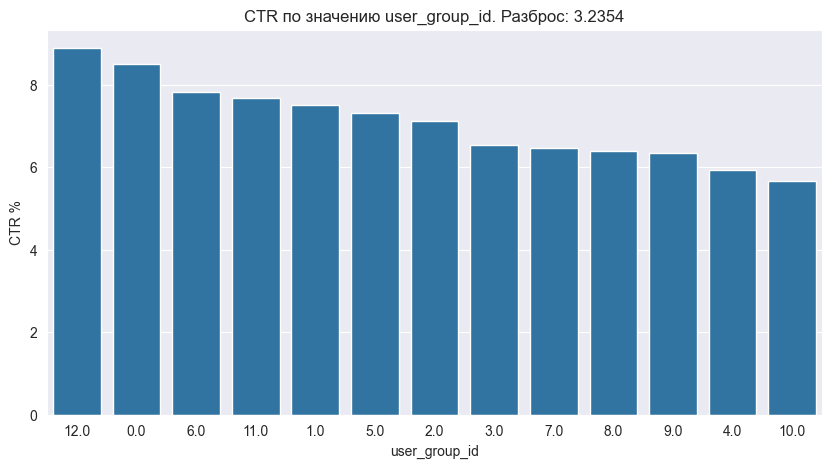

gender
Уникальные значения: ['Female' 'Male']
Распределение:
gender
Male      411697
Female     51594
Name: count, dtype: int64


,count,mean,mean_%
gender,,,
Male,411697,0.0680,6.8026
Female,51594,0.0644,6.4445


Разброс значений 'mean_%': 0.358


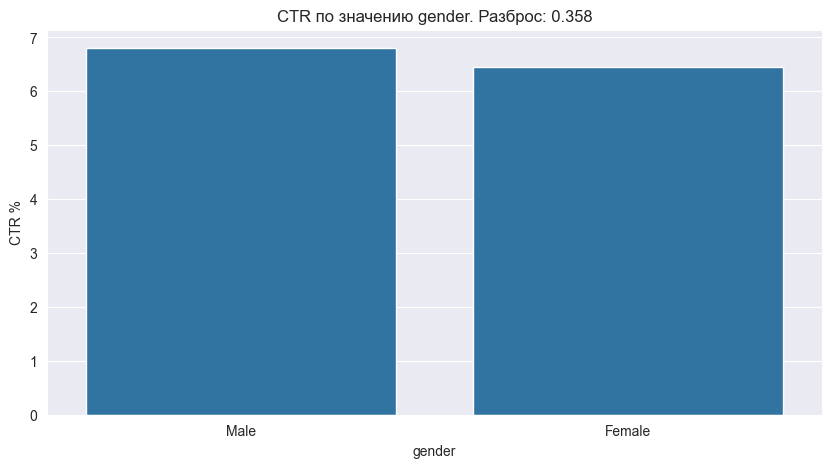

age_level
Уникальные значения: [4. 2. 3. 1. 5. 6. 0.]
Распределение:
age_level
3.0    178824
2.0    143501
4.0     63859
1.0     43367
5.0     30828
6.0      2759
0.0       153
Name: count, dtype: int64


,count,mean,mean_%
age_level,,,
0.0,153,0.0850,8.4967
6.0,2759,0.0823,8.2276
1.0,43367,0.0748,7.4803
5.0,30828,0.0742,7.4153
2.0,143501,0.0709,7.0919
3.0,178824,0.0651,6.5058
4.0,63859,0.0587,5.8723


Разброс значений 'mean_%': 2.6244


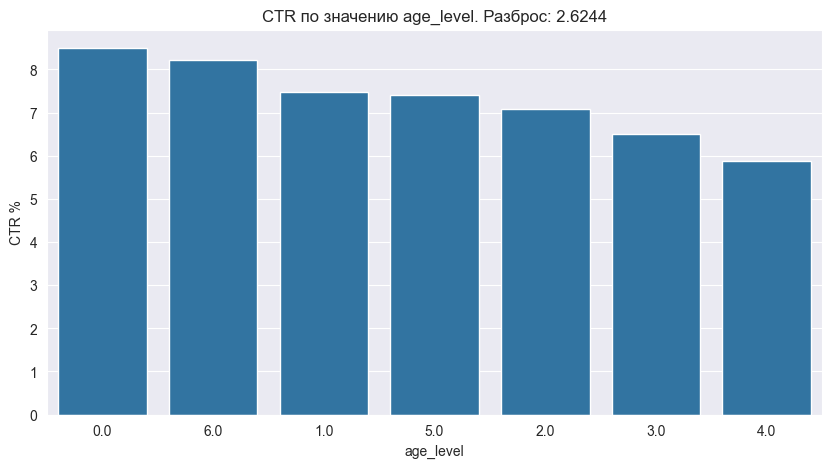

user_depth
Уникальные значения: [3. 2. 1.]
Распределение:
user_depth
3.0    421041
2.0     30389
1.0     11861
Name: count, dtype: int64


,count,mean,mean_%
user_depth,,,
1.0,11861,0.0719,7.1916
3.0,421041,0.0677,6.7658
2.0,30389,0.0655,6.5517


Разброс значений 'mean_%': 0.6399


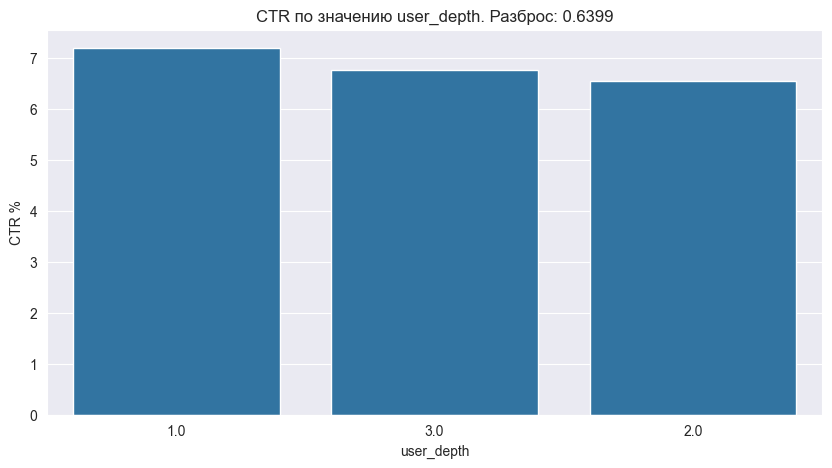

var_1
Уникальные значения: [0 1]
Распределение:
var_1
0    267704
1    195587
Name: count, dtype: int64


,count,mean,mean_%
var_1,,,
1,195587,0.0709,7.0945
0,267704,0.0652,6.5203


Разброс значений 'mean_%': 0.5743


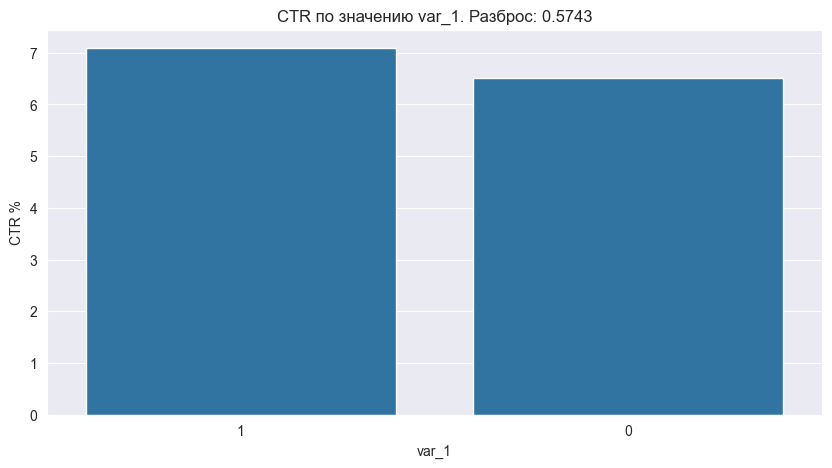

In [27]:
for col in cat_cols:
    get_col_info(col, df)

## Вывод
- Признаки с сильным разбросом (> 2.5%): ***product, campaign_id, webpage_id, user_group_id, age_level, product_category_1***
- Признаки со слабым разбросом (< 1%): ***gender, user_depth, var_1***

Интересно то, что в похожих датасетах обычно var_1 - один из ключевых признаков. Возможно, его сила проявится в комбинации с другими признаками.

# Вывод для EDA:
- Больше всего на клик влияют: продукт, компания (и её вебсайт), группа пользователя, его возраст и категория продукта
- Демография и var_1 не влияют напрямую
- Время даёт небольшой буст рано утром в первые дни недели